In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

In [2]:
df = sns.load_dataset("titanic")

In [3]:
p3_df = df[["age", "fare", "pclass", "sex", "survived"]].copy()
p3_df = p3_df.dropna()
p3_df['sex'] = p3_df['sex'].replace("male", 0)
p3_df['sex'] = p3_df['sex'].replace("female", 1)
np.random.seed(23)
p3_train, p3_validation = np.split(p3_df, [600])

In [72]:
p3_df.head(5)

,age,fare,pclass,sex,survived
0,22.0,7.2500,3,0,0
1,38.0,71.2833,1,1,1
2,26.0,7.9250,3,1,1
3,35.0,53.1000,1,1,1
4,35.0,8.0500,3,0,0


#### Regularization vs. No-Regularization

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In Homework 5, we had you build a Logistic Regression model with polynomial degree 2.

In [6]:
p3c_model = Pipeline([('scale', StandardScaler()),
                      ('poly', PolynomialFeatures(degree=2)),
                      ('model',
                       LogisticRegression(fit_intercept=False,
                                          penalty='none',
                                          solver='lbfgs'))])
p3c_model.fit(p3_train[["fare", "age", "pclass", "sex"]], p3_train["survived"])
;

The coefficients are given below:

In [7]:
p3c_model.named_steps['model'].coef_

array([[-1.13102662, -1.49936142, -0.60810606, -1.63412315,  1.65926409,
         0.16231128,  0.42236562, -0.1055555 , -0.25525431,  0.24084911,
         0.37054654,  0.22395218,  0.70626524, -0.8443333 , -0.18805324]])

We can regularize the model by simply removing `penalty = 'none'`.

In [8]:
p3c_model_regularized = Pipeline([('scale', StandardScaler()),
                                  ('poly', PolynomialFeatures(degree=2)),
                                  ('model',
                                   LogisticRegression(fit_intercept=False,
                                                      solver='lbfgs'))])
p3c_model_regularized.fit(p3_train[["fare", "age", "pclass", "sex"]],
                          p3_train["survived"])
;

Comparing our coefficients, we see that they are slightly smaller overall in the regularized version.

In [9]:
p3c_model.named_steps['model'].coef_

array([[-1.13102662, -1.49936142, -0.60810606, -1.63412315,  1.65926409,
         0.16231128,  0.42236562, -0.1055555 , -0.25525431,  0.24084911,
         0.37054654,  0.22395218,  0.70626524, -0.8443333 , -0.18805324]])

In [10]:
p3c_model_regularized.named_steps['model'].coef_

array([[-0.93868941, -0.95516024, -0.54467238, -1.41258457,  1.49788079,
         0.13732684,  0.38516578,  0.11286982, -0.21226869,  0.19729581,
         0.32346106,  0.20084613,  0.5685718 , -0.73936734, -0.08743148]])

Just as with `LinearRegression`, we can tune the strength of the regularization. Instead of `alpha`, the sklearn authors used the parameter `C`.

Note that `alpha` was proportional to regularization strength. For some reason, the authors of sklearn decided to make `C` inversely proportional to regularization strength.

1. "Strong" regularization (i.e. small coefficients): Large `alpha`, small `C`
2. "Weak" regularization: Small `alpha`, large `C`

For example, if we set `C` = 1e10, we'll see that the coefficients are the same as the unregularized version.

In [11]:
huge_c_model = Pipeline([('scale', StandardScaler()),
                         ('poly', PolynomialFeatures(degree=2)),
                         ('model',
                          LogisticRegression(fit_intercept=False,
                                             C=1e10,
                                             solver='lbfgs'))])
huge_c_model.fit(p3_train[["fare", "age", "pclass", "sex"]],
                 p3_train["survived"])
;

In [12]:
p3c_model.named_steps['model'].coef_

array([[-1.13102662, -1.49936142, -0.60810606, -1.63412315,  1.65926409,
         0.16231128,  0.42236562, -0.1055555 , -0.25525431,  0.24084911,
         0.37054654,  0.22395218,  0.70626524, -0.8443333 , -0.18805324]])

In [13]:
huge_c_model.named_steps['model'].coef_

array([[-1.13102662, -1.49936142, -0.60810606, -1.63412315,  1.65926409,
         0.16231128,  0.42236562, -0.1055555 , -0.25525431,  0.24084911,
         0.37054654,  0.22395218,  0.70626524, -0.8443333 , -0.18805324]])

Whereas if we pick a tiny `C`, e.g. 1e-8, the model is strongly regularized and the coefficients are very small.

In [14]:
tiny_c_model = Pipeline([('scale', StandardScaler()),
                         ('poly', PolynomialFeatures(degree=2)),
                         ('model',
                          LogisticRegression(fit_intercept=False,
                                             C=1e-7,
                                             solver='lbfgs'))])
tiny_c_model.fit(p3_train[["fare", "age", "pclass", "sex"]],
                 p3_train["survived"])
;

In [15]:
tiny_c_model.named_steps['model'].coef_

array([[-5.60010955e-06,  7.51111139e-06, -2.65116592e-06,
        -1.03234319e-05,  1.56655089e-05,  1.54931392e-05,
         1.14096696e-06, -3.34372037e-06,  1.91122677e-06,
        -5.34841905e-06,  2.87967040e-06,  1.77226488e-06,
        -2.00775812e-06, -3.98826178e-06,  3.30272756e-06]])

In [16]:
def compute_titanic_accuracy(model, data):
    y_hat_class = model.predict(data[["fare", "age", "pclass", "sex"]])
    y_obs = data["survived"]
    return sum(y_hat_class == y_obs) / len(y_hat_class)

In [17]:
compute_titanic_accuracy(tiny_c_model, p3_train)

0.7716666666666666

In [18]:
compute_titanic_accuracy(huge_c_model, p3_train)

0.8333333333333334

In [19]:
def get_train_and_validation_accuracy(C):
    c_model = Pipeline([('scale', StandardScaler()),
                        ('poly', PolynomialFeatures(degree=2)),
                        ('model',
                         LogisticRegression(fit_intercept=False,
                                            C=C,
                                            max_iter=10000,
                                            solver='lbfgs'))])
    c_model.fit(p3_train[["fare", "age", "pclass", "sex"]],
                p3_train["survived"])

    training_accuracy = compute_titanic_accuracy(c_model, p3_train)
    val_accuracy = compute_titanic_accuracy(c_model, p3_validation)

    return training_accuracy, val_accuracy

In [20]:
get_train_and_validation_accuracy(1e-2)

(0.7766666666666666, 0.8070175438596491)

In [21]:
accuracies = [
    get_train_and_validation_accuracy(C) for C in 10**np.linspace(-7, 5, 100)
]

In [22]:
max(np.array(accuracies)[:, 1])

0.8508771929824561

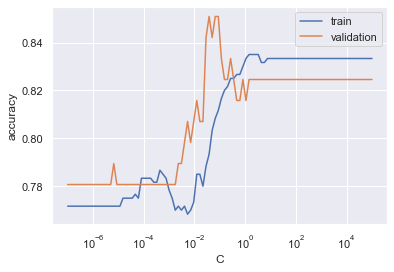

In [23]:
plt.semilogx(10**np.linspace(-7, 5, 100), accuracies)
plt.legend(['train', 'validation'])
plt.ylabel('accuracy')
plt.xlabel('C')
plt.savefig('training_and_validation_error_vs_C_with_intercept.png',
            dpi=300,
            bbox_inches='tight')

#### Cross Validation for C Selection

Using `LogisticRegressionCV` lets us automatically select the best C. 

In [24]:
cv_model = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model',
     LogisticRegressionCV(fit_intercept=False,
                          Cs=10**np.linspace(-7, 5, 100),
                          cv=3))  # 交叉验证数为3
])
cv_model.fit(p3_df[["fare", "age", "pclass", "sex"]], p3_df["survived"])

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('model',
                 LogisticRegressionCV(Cs=array([1.00000000e-07, 1.32194115e-07, 1.74752840e-07, 2.31012970e-07,
       3.05385551e-07, 4.03701726e-07, 5.33669923e-07, 7.05480231e-07,
       9.326033...
       1.41747416e+04, 1.87381742e+04, 2.47707636e+04, 3.27454916e+04,
       4.32876128e+04, 5.72236766e+04, 7.56463328e+04, 1.00000000e+05]),
                                      class_weight=None, cv=3, dual=False,
                                      fit_intercept=False,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=100, multi_class='warn',
                                      n_jobs=None, penalty

In [25]:
cv_model.named_steps["model"].C_

array([30.53855509])

In HW6, there is an optional exercise that shows an alternate better technique for picking optimal C.

#### Cross Entropy Loss

In [26]:
delta_y = np.linspace(0, 1, 1000)

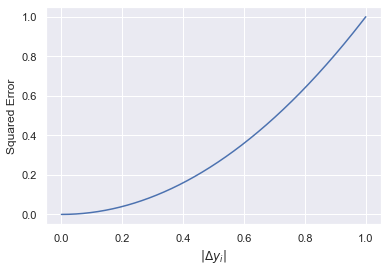

In [27]:
mse = delta_y**2
plt.plot(delta_y, mse)
plt.xlabel('$|\Delta y_i|$')
plt.ylabel('Squared Error')
plt.savefig('MSE_vs_delta_y.png', dpi=300, bbox_inches="tight")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



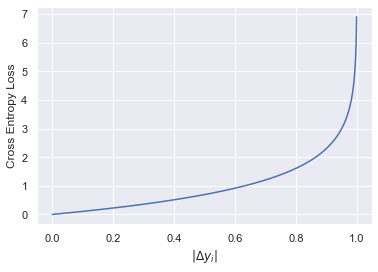

In [47]:
cross_entropy = -np.log(1 - delta_y)
plt.plot(delta_y, cross_entropy)
plt.xlabel('$|\Delta y_i|$')
plt.ylabel('Cross Entropy Loss')
plt.savefig('CELoss_vs_delta_y.png', dpi=300, bbox_inches="tight")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


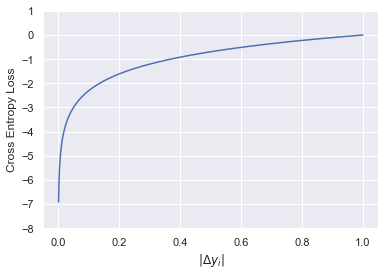

In [29]:
cross_entropy1 = np.log(delta_y)
plt.plot(delta_y, cross_entropy1)
plt.ylim(-8, 1)
plt.xlabel('$|\Delta y_i|$')
plt.ylabel('Cross Entropy Loss')
# plt.savefig('CELoss_vs_delta_y.png', dpi = 300, bbox_inches = "tight")

In [30]:
from lec5_utils import loss_plot_3d
from lec5_utils import loss_contour_plot

In [31]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

In [32]:
from sklearn.metrics import log_loss

In [33]:
log_loss(["win", "lose", "win", "lose"], [0.9, 0.8, 0.6, 0.2])

0.6121919007930319

In [34]:
log_loss([1, 0, 1, 0], [0.9, 0.8, 0.6, 0.2])

0.6121919007930319

In [35]:
def mean_ce_loss(theta0, theta1, x, y_obs):
    y_hat = sigma(theta0 + theta1 * x)
    return log_loss(y_obs, y_hat)

In [36]:
nba = pd.read_csv(r"data_set\nba.csv")
nba["WON"] = nba["WL"]
nba["WON"] = nba["WON"].replace("W", 1)
nba["WON"] = nba["WON"].replace("L", 0)

In [37]:
mean_ce_loss(theta0=-11, theta1=0.1, x=nba["PTS"], y_obs=nba["WON"])

0.5725397505600823

In [ ]:
theta0s = np.linspace(-11, 0, 10)
theta1s = np.linspace(0, 0.3, 10)
loss_plot_3d(theta0s, theta1s, mean_ce_loss, nba["PTS"], nba["WON"])

In [ ]:
theta0s = np.linspace(-11, 0, 20)
theta1s = np.linspace(0, 0.3, 20)
loss_contour_plot(theta0s,
                  theta1s,
                  mean_ce_loss,
                  nba["PTS"],
                  nba["WON"],
                  flip_axes=True)

In [52]:
def get_train_and_validation_ce_loss(C, degree):
    c_model = Pipeline([('scale', StandardScaler()),
                        ('poly', PolynomialFeatures(degree=degree)),
                        ('model',
                         LogisticRegression(fit_intercept=False,
                                            C=C,
                                            max_iter=10000,
                                            solver='lbfgs'))])
    c_model.fit(p3_train[["fare", "age", "pclass", "sex"]],
                p3_train["survived"])

    training_predictions = c_model.predict_proba(
        p3_train[["fare", "age", "pclass", "sex"]])
    train_ce = log_loss(p3_train["survived"], training_predictions)

    validation_predictions = c_model.predict_proba(
        p3_validation[["fare", "age", "pclass", "sex"]])
    validation_ce = log_loss(p3_validation["survived"], validation_predictions)

    return train_ce, validation_ce

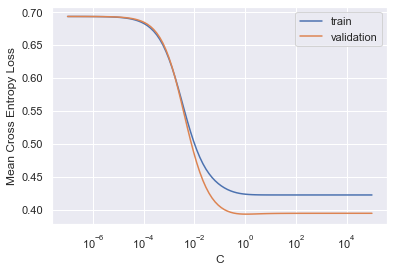

In [53]:
ce_losses = [
    get_train_and_validation_ce_loss(C, 2) for C in 10**np.linspace(-7, 5, 100)
]
plt.semilogx(10**np.linspace(-7, 5, 100), ce_losses)
plt.legend(['train', 'validation'])
plt.ylabel('Mean Cross Entropy Loss')
plt.xlabel('C')
plt.savefig("cross-entropy-loss-vs-c-degree-2.png",
            dpi=300,
            bbox_inches="tight")

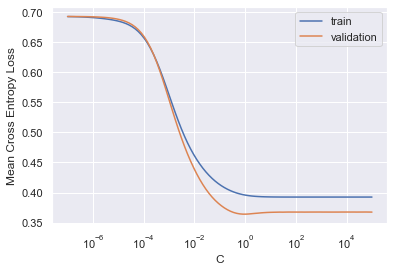

In [55]:
ce_losses = [
    get_train_and_validation_ce_loss(C, 3) for C in 10**np.linspace(-7, 5, 100)
]
plt.semilogx(10**np.linspace(-7, 5, 100), ce_losses)
plt.legend(['train', 'validation'])
plt.ylabel('Mean Cross Entropy Loss')
plt.xlabel('C')
plt.savefig("cross-entropy-loss-vs-c-degree-3.png",
            dpi=300,
            bbox_inches="tight")

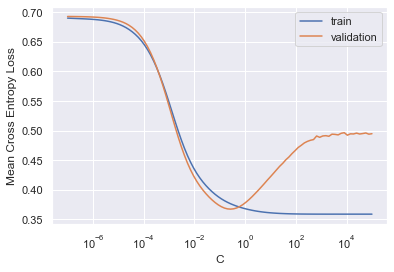

In [54]:
ce_losses = [
    get_train_and_validation_ce_loss(C, 4) for C in 10**np.linspace(-7, 5, 100)
]
plt.semilogx(10**np.linspace(-7, 5, 100), ce_losses)
plt.legend(['train', 'validation'])
plt.ylabel('Mean Cross Entropy Loss')
plt.xlabel('C')
plt.savefig("cross-entropy-loss-vs-c-degree-4.png",
            dpi=300,
            bbox_inches="tight")

#### Intercept Regularization

Throughout the code above, we've ben setting `fit_intercept = False`. The reason for this is that we are using the `PolynomialFeatures` module, which automatically creates a feature that is always equal to 1.

For example, if we pick degree = 2 and use the features "fare", "age", "pclass", and "sex", we'll get the following features:

In [57]:
pf = PolynomialFeatures(degree=2)
pf.fit(p3_train[["fare", "age", "pclass", "sex"]])
feature_names = pf.get_feature_names(["fare", "age", "pclass", "sex"])
feature_names

['1',
 'fare',
 'age',
 'pclass',
 'sex',
 'fare^2',
 'fare age',
 'fare pclass',
 'fare sex',
 'age^2',
 'age pclass',
 'age sex',
 'pclass^2',
 'pclass sex',
 'sex^2']

In [58]:
pd.DataFrame(pf.transform(p3_train[["fare", "age", "pclass", "sex"]]),
             columns=feature_names)

,1,fare,age,pclass,sex,fare^2,fare age,fare pclass,fare sex,age^2,age pclass,age sex,pclass^2,pclass sex,sex^2
0,1.0,7.2500,22.0,3.0,0.0,52.562500,159.5000,21.7500,0.0000,484.0,66.0,0.0,9.0,0.0,0.0
1,1.0,71.2833,38.0,1.0,1.0,5081.308859,2708.7654,71.2833,71.2833,1444.0,38.0,38.0,1.0,1.0,1.0
2,1.0,7.9250,26.0,3.0,1.0,62.805625,206.0500,23.7750,7.9250,676.0,78.0,26.0,9.0,3.0,1.0
3,1.0,53.1000,35.0,1.0,1.0,2819.610000,1858.5000,53.1000,53.1000,1225.0,35.0,35.0,1.0,1.0,1.0
4,1.0,8.0500,35.0,3.0,0.0,64.802500,281.7500,24.1500,0.0000,1225.0,105.0,0.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.0,53.1000,19.0,1.0,0.0,2819.610000,1008.9000,53.1000,0.0000,361.0,19.0,0.0,1.0,0.0,0.0
596,1.0,7.7500,31.0,3.0,0.0,60.062500,240.2500,23.2500,0.0000,961.0,93.0,0.0,9.0,0.0,0.0
597,1.0,23.0000,4.0,2.0,1.0,529.000000,92.0000,46.0000,23.0000,16.0,8.0,4.0,4.0,2.0,1.0
598,1.0,12.4750,6.0,3.0,0.0,155.625625,74.8500,37.4250,0.0000,36.0,18.0,0.0,9.0,0.0,0.0


If we set `fit_intercept = False`, then our first coefficient is our intercept.

In [60]:
unregularized_model_intercept_false = Pipeline([
    ('scale', StandardScaler()), ('poly', PolynomialFeatures(degree=1)),
    ('model',
     LogisticRegression(fit_intercept=False, penalty='none', solver='lbfgs'))
])
unregularized_model_intercept_false.fit(
    p3_train[["fare", "age", "pclass", "sex"]], p3_train["survived"])
;

In [61]:
unregularized_model_intercept_false.named_steps['model'].coef_

array([[-0.5120583 , -0.00927245, -0.47776382, -1.06434141,  1.19627839]])

In [62]:
unregularized_model_intercept_false.named_steps['model'].intercept_

array([0.])

The model also has a variable called `intercept_`, but it's equal to zero. This is because we set `fit_intercept = False`. Note that even though the `intercept_` is zero, we actually do have an intercept of 0.51 because of the bias feature we created that is always equal to 1.

Thus, our model makes a prediction equal to $\sigma(0 - 0.51 \times 1 - 0.009 \times \text{fare} - 0.478 \times \text{age} - 1.06 \times \text{pclass} + 1.196 \times \text{sex}$.

Let's see what happens when we set `fit_intercept = True`.

In [65]:
unregularized_model_intercept_true = Pipeline([
    ('scale', StandardScaler()), ('poly', PolynomialFeatures(degree=1)),
    ('model',
     LogisticRegression(fit_intercept=True, penalty='none', solver='lbfgs'))
])
unregularized_model_intercept_true.fit(
    p3_train[["fare", "age", "pclass", "sex"]], p3_train["survived"])
;

In [66]:
unregularized_model_intercept_true.named_steps["model"].coef_

array([[-0.25602854, -0.00927195, -0.47776545, -1.06434099,  1.19627759]])

This time, we see that our model is exactly the same, except that the weight of our bias feature is only -0.256. However, if we look at our `intercept_`, we see that it is also -0.256. Effectively, we have two redundant intercepts which, when added, are equal to 0.51.

In [67]:
unregularized_model_intercept_true.named_steps["model"].intercept_

array([-0.25602854])

In other words:

`unregularized_model_intercept_false` was equal to $\sigma(0 - 0.51 \times 1 - 0.009 \times \text{fare} - 0.478 \times \text{age} - 1.06 \times \text{pclass} + 1.196 \times \text{sex}$

and `unreularized_model_intercept_true` was equal to $\sigma(0.256 - 0.256 \times 1 - 0.009 \times \text{fare} - 0.478 \times \text{age} - 1.06 \times \text{pclass} + 1.196 \times \text{sex}$

There is no difference between these models. However, things get more complicated when we have a regularized model. To understand why, let's see what happens when we remove `penalty = 'none'`, and let's pick a very small `C`.

In [69]:
tiny_c_model_intercept_true = Pipeline([('scale', StandardScaler()),
                                        ('poly', PolynomialFeatures(degree=1)),
                                        ('model',
                                         LogisticRegression(fit_intercept=True,
                                                            C=1e-7,
                                                            solver='lbfgs'))])
tiny_c_model_intercept_true.fit(p3_train[["fare", "age", "pclass", "sex"]],
                                p3_train["survived"])
;

As you'd expect, the thetas generated by our model are very small, because `C` is very small.

In [70]:
tiny_c_model_intercept_true.named_steps["model"].coef_

array([[ 1.49126446e-13,  7.51210438e-06, -2.65108958e-06,
        -1.03239147e-05,  1.56655731e-05]])

However, the `intercept_` is NOT regularized. As you can see below, the `intercept_` is -0.377, which is enormous compared to our other coefficients.

In [71]:
tiny_c_model_intercept_true.named_steps["model"].intercept_

array([-0.37776248])

In [83]:
tiny_c_model_intercept_true_reg = Pipeline([
    ('scale', StandardScaler()), ('poly', PolynomialFeatures(degree=1)),
    ('model',
     LogisticRegression(fit_intercept=True,
                        penalty='none',
                        C=1e-7,
                        solver='lbfgs'))
])
tiny_c_model_intercept_true_reg.fit(p3_train[["fare", "age", "pclass", "sex"]],
                                    p3_train["survived"])
;

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters



In [84]:
tiny_c_model_intercept_true_reg.named_steps["model"].coef_

array([[-0.25602854, -0.00927195, -0.47776545, -1.06434099,  1.19627759]])

In [85]:
tiny_c_model_intercept_true_reg.named_steps["model"].intercept_

array([-0.25602854])

In effect, we have two intercepts, one of which is subject to regularization (and is almost equal to 0), and one of which is not.

Common convention in machine learning is to include an unregularized intercept. This gives your model additional freedom to select an intercept which minimizes the cross entropy loss.

**Bottom line:** I recommend always setting `fit_intercept = True` when using a regularized model.

We can compare the performance of a model with regularized and unregularized intercept using the `log_loss`.

In [76]:
tiny_c_model_intercept_false = Pipeline([
    ('scale', StandardScaler()), ('poly', PolynomialFeatures(degree=1)),
    ('model', LogisticRegression(fit_intercept=False, C=1e-7, solver='lbfgs'))
])
tiny_c_model_intercept_false.fit(p3_train[["fare", "age", "pclass", "sex"]],
                                 p3_train["survived"])
;

In [79]:
tiny_c_model_intercept_false.named_steps["model"].intercept_

array([0.])

In [80]:
tiny_c_model_intercept_false.named_steps["model"].coef_

array([[-5.59991600e-06,  7.51223534e-06, -2.65118506e-06,
        -1.03236932e-05,  1.56656209e-05]])

We see that cross entropy loss is slightly better when we include an unregularized intercept. We will explore this more fully on hw6.

In [81]:
log_loss(
    p3_train["survived"],
    tiny_c_model_intercept_true.predict_proba(
        p3_train[["fare", "age", "pclass", "sex"]]))

0.6756154189994156

In [82]:
log_loss(
    p3_train["survived"],
    tiny_c_model_intercept_false.predict_proba(
        p3_train[["fare", "age", "pclass", "sex"]]))

0.693139733620562